# Audio UX

Task mAIstro supports voice interactions using:
- [OpenAI's Whisper](https://platform.openai.com/docs/guides/speech-to-text) for speech-to-text
- [ElevenLabs](https://github.com/elevenlabs/elevenlabs-python) for text-to-speech

### Install dependencies

Ensure you have `ffmpeg` installed for using ElevenLabs. 

On MacOS, you can install it with `brew install ffmpeg`. 

In [16]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core sounddevice scipy elevenlabs 

### Set environment variables

* Set your `OPENAI_API_KEY`
* Set your `ELEVENLABS_API_KEY` (available [here](https://elevenlabs.io/api))
* Optional: Set your `LANGCHAIN_API_KEY` (available [here](https://smith.langchain.com/)) if you want tracing or want to connect with a hosted deployment.

In [19]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
elevenlabs_api_key = os.getenv("ELEVENLABS_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
# def _set_env(var: str):
#     # Check if the variable is set in the OS environment
#     env_value = os.environ.get(var)
#     if not env_value:
#         # If not set, prompt the user for input
#         env_value = getpass.getpass(f"{var}: ")
    
#     # Set the environment variable for the current process
#     os.environ[var] = env_value

# _set_env("LANGCHAIN_API_KEY")
# _set_env("ELEVENLABS_API_KEY")
# _set_env("OPENAI_API_KEY")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "task-maistro-deployment"

### Connect to your deployment

Connect to your deployment using the URL endpoint:
- **Studio**: Found in Studio UI 
- **CLI**: Printed to console (typically `http://localhost:8123`)
- **Cloud**: Available in LangGraph Deployment page

We'll connect to the deployment as a [RemoteGraph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#how-to-interact-with-the-deployment-using-remotegraph). 


In [20]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Local deployment
local_deployment_url = "http://localhost:8123"

# Deployment URL
cloud_deployment_url = "https://task-maistro-1b681add7a2b549499bb0cd21a7e5be4.default.us.langgraph.app"

# Graph name
graph_name = "task_maistro" 

# Connect to the deployment
remote_graph = RemoteGraph(graph_name, url=local_deployment_url)

You can test your deployment by running the following. 

In [21]:
# Int
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Test-Deployment-User"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_mCJ6OcAoWPXMUlFzkvcaUEHl)
 Call ID: call_mCJ6OcAoWPXMUlFzkvcaUEHl
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it, Lance! I've updated your profile with the information about where you live and your family. How can I assist you today?


### Add audio

Our deployed graph has some benefits: 
* It has built-in support for long-term memory 
* It implements all the logic for task mAIstro 

But, we have a challenge:
* It takes test as input and returns text as output

We need to add audio input and output to the graph. So, we'll simply add two nodes to our graph:

1. **Audio Input Node**
   * Records microphone input (stop with Enter)
   * Transcribes speech using Whisper
   * Passes text to Task mAIstro

2. **Audio Output Node**
   * Takes Task mAIstro's text response
   * Converts to speech via ElevenLabs
   * Plays audio response

We can achieve this by embedding our deployed graph [as a node](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#using-as-a-subgraph) in a new graph. 

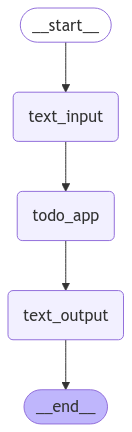

In [27]:
import os
from IPython.display import Image, display
from openai import OpenAI
from langgraph.graph import StateGraph, MessagesState, END, START
from langchain.schema import HumanMessage

# Initialize OpenAI client
openai_client = OpenAI()

def get_user_input(state: MessagesState):
    """Prompts the user to input text instead of recording audio."""
    user_input = input("Please enter your instruction: ")
    
    # Return user input as a message
    return {"messages": [HumanMessage(content=user_input)]}

def display_response(state: MessagesState):
    """Displays the text response from the graph."""
    response = state["messages"][-1]
    print("Response from the system:", response.content)

# Define the graph
builder = StateGraph(MessagesState)

# Add nodes for text input and response display
builder.add_node("text_input", get_user_input)
builder.add_node("todo_app", remote_graph)  # Assuming `remote_graph` is defined elsewhere
builder.add_node("text_output", display_response)
builder.add_edge(START, "text_input")
builder.add_edge("text_input", "todo_app")
builder.add_edge("todo_app", "text_output")
builder.add_edge("text_output", END)

# Compile the graph
graph = builder.compile()

# Display the graph structure
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


Optionally, you can supply a thread ID to ensure that conversation history is persisted. 

In [28]:
import uuid
thread_id = str(uuid.uuid4())

In [30]:
# Set user ID for storing memories
config = {"configurable": {"user_id": "Test-Text-UX", "thread_id": thread_id}}

# Prompt the user for text input
user_input = input("Please enter your instruction: ")

# Kick off the graph with the user's text input
for chunk in graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    # Print the last message in the response
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================


================================ Human Message =================================

add a todo to throw my garbage
================================== Ai Message ==================================

I have added the task to throw your garbage to your ToDo list.
Response from the system: I have added the task to throw your garbage to your ToDo list.


Simply, run this cell and speak into your microphone. When you are finished, press Enter.